# US immigrant datawarehouse
### Data Engineering Capstone Project

#### Project Summary
The project consists of creating an ETL for the 2016 immigration data warehouse. Considering the demographics and airports of the US.

The project follows the follow steps:
* Step 1: Scope the Project and Gather Data
* Step 2: Explore and Assess the Data
* Step 3: Define the Data Model
* Step 4: Run ETL to Model the Data
* Step 5: Complete Project Write Up

In [1]:
# Do all imports and installs here
import boto3
import psycopg2
import numpy as np
import configparser
import pandas as pd
import os, time,csv
import seaborn as sns
import missingno as msno
from matplotlib import pyplot as plt
from pyspark.sql import SparkSession
from datetime import datetime, timedelta
from pyspark.sql.types import TimestampType, StringType, IntegerType
from pyspark.sql.functions import udf, col, monotonically_increasing_id, when, count, col, isnull
from pyspark.sql.functions import hour, dayofmonth, dayofweek, month, year, weekofyear, from_unixtime, to_timestamp, date_format
sns.set()

In [2]:
config = configparser.ConfigParser()
config.read('dl.cfg')


['dl.cfg']

In [3]:
os.environ["AWS_DEFAULT_REGION"] = 'us-west-2'
os.environ['AWS_ACCESS_KEY_ID']=config['AWS']['AWS_ACCESS_KEY_ID']
os.environ['AWS_SECRET_ACCESS_KEY']=config['AWS']['AWS_SECRET_ACCESS_KEY']
BKS3A = config['S3']['BUCKET_S3A']
BKS3 = config['S3']['BUCKET_S3']

In [ ]:
conn = psycopg2.connect("host={} dbname={} user={} password={} port={}".format(*config['CLUSTER'].values()))
cur = conn.cursor()

## Project scope

The project consists of creating a snowflake model that has 6 dimensions and a fact table. This information is extracted from the following data sets: I94 Immigration Data, U.S. City Demographic Data and Airport Code Table.

The tools to use are amazon S3, spark, pandas, airflow and amazon redshift


## Description of the data

#### Description airport-codes
This information comes from datahub.io and contains the list of all airport codes, the attributes are identified in the description of the data package. Some of the columns contain attributes that identify the airport locations, other codes (IATA, local if any) that are relevant for identifying an airport.

<table class="tg" align="left">
  <tbody><tr>
    <th class="tg-0pky">Fields</th>
    <th class="tg-0pky">Description</th>
  </tr>
 <tr>
<td class="tg-0pky">ident</td>
<td class="tg-0pky">Airport identifier</td>
 </tr>
<tr>
<td class="tg-0pky">type</td>
<td class="tg-0pky">Airport size</td>
 </tr>
<tr>
<td class="tg-0pky">name</td>
<td class="tg-0pky">Airport name</td>
 </tr>
<tr>
<td class="tg-0pky">elevation_ft</td>
<td class="tg-0pky">elevation feet</td>
 </tr>
<tr>
<td class="tg-0pky">iso_country</td>
<td class="tg-0pky">Codes are two-letter country codes </td>
 </tr>
<tr>
<td class="tg-0pky">iso_region</td>
<td class="tg-0pky">Contains a set of 2-digit region codes</td>
 </tr>
<tr>
<td class="tg-0pky">municipality</td>
<td class="tg-0pky">Municipality</td>
 </tr>
<tr>
<td class="tg-0pky">gps_code</td>
<td class="tg-0pky">Airport codes is used to display an airport's location identifiers or "airport codes".</td>
 </tr>
<tr>
<td class="tg-0pky">iata_code</td>
<td class="tg-0pky">IATA location identifier</td>
 </tr>
<tr>
<td class="tg-0pky">local_code</td>
<td class="tg-0pky">local code</td>
 </tr>
<tr>
<td class="tg-0pky">coordinates</td>
<td class="tg-0pky">coordinates</td>
 </tr>
</tbody></table>

In [4]:
# Read in the data here
df_airport = pd.read_csv('airport-codes_csv.csv', encoding="ISO-8859-1")
df_airport.head()                                                                          

ident           type                                name  elevation_ft  \
0   00A       heliport                   Total Rf Heliport          11.0   
1  00AA  small_airport                Aero B Ranch Airport        3435.0   
2  00AK  small_airport                        Lowell Field         450.0   
3  00AL  small_airport                        Epps Airpark         820.0   
4  00AR         closed  Newport Hospital & Clinic Heliport         237.0   

  continent iso_country iso_region  municipality gps_code iata_code  \
0       NaN          US      US-PA      Bensalem      00A       NaN   
1       NaN          US      US-KS         Leoti     00AA       NaN   
2       NaN          US      US-AK  Anchor Point     00AK       NaN   
3       NaN          US      US-AL       Harvest     00AL       NaN   
4       NaN          US      US-AR       Newport      NaN       NaN   

  local_code                            coordinates  
0        00A     -74.93360137939453, 40.07080078125  
1       00AA                 -101.473911, 38.704022  
2       00AK            -151.695999146, 59.94919968  
3       00AL  -86.77030181884766, 34.86479949951172  
4        NaN                    -91.254898, 35.6087

#### Description immigration_data
This data comes from the US National Tourism and Trade Office. This report contains international visitor arrival statistics by world regions and selected countries (including the top 20), visa type, mode of transport, age groups, states visited (only the first expected address) and the main ports of entry (for selected countries). This information corresponds to 2016.
<table class="tg" align="left">
  <tbody><tr>
    <th class="tg-0pky">Fields</th>
    <th class="tg-0pky">Description</th>
  </tr>
 <tr>
<td class="tg-0pky">cicid</td>
<td class="tg-0pky">CICID is a unique number for the immigrants</td>
 </tr>
<tr>
<td class="tg-0pky">i94yr</td>
<td class="tg-0pky">4 digit year</td>
 </tr>
<tr>
<td class="tg-0pky">i94mon</td>
<td class="tg-0pky">Numeric month</td>
 </tr>
<tr>
<td class="tg-0pky">i94cit</td>
<td class="tg-0pky">3 digit code of origin city</td>
 </tr>
<tr>
<td class="tg-0pky">i94res</td>
<td class="tg-0pky">Country from where one has travelled</td>
 </tr>
<tr>
<td class="tg-0pky">i94port</td>
<td class="tg-0pky">3 character code of destination USA city</td>
 </tr>
<tr>
<td class="tg-0pky">arrdate</td>
<td class="tg-0pky">Date of arrrival</td>
 </tr>
<tr>
<td class="tg-0pky">i94mode</td>
<td class="tg-0pky">1 digit travel code  (1 = Air; 2 = Sea; 3 = Land; 9 = Not reported)</td>
 </tr>
<tr>
<td class="tg-0pky">i94addr</td>
<td class="tg-0pky">Where the immigrants resides in USA </td>
 </tr>
<tr>
<td class="tg-0pky">depdate</td>
<td class="tg-0pky">Departure Date from the USA</td>
 </tr>
<tr>
<td class="tg-0pky">i94bir</td>
<td class="tg-0pky">Age of Respondent in Years</td>
 </tr>
<tr>
<td class="tg-0pky">i94visa</td>
<td class="tg-0pky">Visa codes collapsed into three categories (1 = Business; 2 = Pleasure; 3 = Student)</td>
 </tr>
<tr>
<td class="tg-0pky">count</td>
<td class="tg-0pky">Used for summary statistics</td>
 </tr>
<tr>
<td class="tg-0pky">dtadfile</td>
<td class="tg-0pky">Character Date Field - Date added to I-94 Files</td>
 </tr>
<tr>
<td class="tg-0pky">visapost</td>
<td class="tg-0pky">Department of State where where Visa was issued </td>
 </tr>
<tr>
<td class="tg-0pky">occup</td>
<td class="tg-0pky">Occupation that will be performed in U.S</td>
 </tr>
<tr>
<td class="tg-0pky">entdepa</td>
<td class="tg-0pky">Arrival Flag - admitted or paroled into the U.S.</td>
 </tr>
<tr>
<td class="tg-0pky">entdepd</td>
<td class="tg-0pky">Departure Flag - Departed, lost I-94 or is deceased</td>
 </tr>
<tr>
<td class="tg-0pky">entdepu</td>
<td class="tg-0pky">Update Flag - Either apprehended, overstayed, adjusted to perm residence</td>
 </tr>
<tr>
<td class="tg-0pky">matflag</td>
<td class="tg-0pky">Match flag - Match of arrival and departure records</td>
 </tr>
<tr>
<td class="tg-0pky">biryear</td>
<td class="tg-0pky">4 digit year of birth</td>
 </tr>
<tr>
<td class="tg-0pky">dtaddto</td>
<td class="tg-0pky">Character Date Field - Date to which admitted to U.S. (allowed to stay until)</td>
 </tr>
<tr>
<td class="tg-0pky">gender</td>
<td class="tg-0pky">Non-immigrant sex</td>
 </tr>
<tr>
<td class="tg-0pky">insnum</td>
<td class="tg-0pky">INS number</td>
 </tr>
<tr>
<td class="tg-0pky">airline</td>
<td class="tg-0pky">Airline used to arrive in U.S.</td>
 </tr>
<tr>
<td class="tg-0pky">admnum</td>
<td class="tg-0pky">Admission Number</td>
 </tr>
<tr>
<td class="tg-0pky">fltno</td>
<td class="tg-0pky">Flight number of Airline used to arrive in U.S.</td>
 </tr>
<tr>
<td class="tg-0pky">visatype</td>
<td class="tg-0pky">Class of admission legally admitting the non-immigrant to temporarily stay in U.S.</td>
</tr>
</tbody></table>

In [6]:
# Read in the data here
df = pd.read_csv('immigration_data_sample.csv', encoding="ISO-8859-1")
df.head()

Unnamed: 0      cicid   i94yr  i94mon  i94cit  i94res i94port  arrdate  \
0     2027561  4084316.0  2016.0     4.0   209.0   209.0     HHW  20566.0   
1     2171295  4422636.0  2016.0     4.0   582.0   582.0     MCA  20567.0   
2      589494  1195600.0  2016.0     4.0   148.0   112.0     OGG  20551.0   
3     2631158  5291768.0  2016.0     4.0   297.0   297.0     LOS  20572.0   
4     3032257   985523.0  2016.0     4.0   111.0   111.0     CHM  20550.0   

   i94mode i94addr  depdate  i94bir  i94visa  count  dtadfile visapost occup  \
0      1.0      HI  20573.0    61.0      2.0    1.0  20160422      NaN   NaN   
1      1.0      TX  20568.0    26.0      2.0    1.0  20160423      MTR   NaN   
2      1.0      FL  20571.0    76.0      2.0    1.0  20160407      NaN   NaN   
3      1.0      CA  20581.0    25.0      2.0    1.0  20160428      DOH   NaN   
4      3.0      NY  20553.0    19.0      2.0    1.0  20160406      NaN   NaN   

  entdepa entdepd  entdepu matflag  biryear   dtaddto gender  insnum airline  \
0       G       O      NaN       M   1955.0  07202016      F     NaN      JL   
1       G       R      NaN       M   1990.0  10222016      M     NaN     *GA   
2       G       O      NaN       M   1940.0  07052016      M     NaN      LH   
3       G       O      NaN       M   1991.0  10272016      M     NaN      QR   
4       Z       K      NaN       M   1997.0  07042016      F     NaN     NaN   

         admnum  fltno visatype  
0  5.658267e+10  00782       WT  
1  9.436200e+10  XBLNG       B2  
2  5.578047e+10  00464       WT  
3  9.478970e+10  00739       B2  
4  4.232257e+10   LAND       WT

In [4]:
spark = SparkSession.builder.\
    config('spark.jars.packages','org.apache.hadoop:hadoop-aws:2.7.0,saurfang:spark-sas7bdat:2.1.0-s_2.11').\
    enableHiveSupport().getOrCreate()

In [5]:
df_spark = spark.read.format('com.github.saurfang.sas.spark').load('../data/18-83510-I94-Data-2016/i94_apr16_sub.sas7bdat')
df_spark.show(5)

+-----+------+------+------+------+-------+-------+-------+-------+-------+------+-------+-----+--------+--------+-----+-------+-------+-------+-------+-------+--------+------+------+-------+--------------+-----+--------+
|cicid| i94yr|i94mon|i94cit|i94res|i94port|arrdate|i94mode|i94addr|depdate|i94bir|i94visa|count|dtadfile|visapost|occup|entdepa|entdepd|entdepu|matflag|biryear| dtaddto|gender|insnum|airline|        admnum|fltno|visatype|
+-----+------+------+------+------+-------+-------+-------+-------+-------+------+-------+-----+--------+--------+-----+-------+-------+-------+-------+-------+--------+------+------+-------+--------------+-----+--------+
|  6.0|2016.0|   4.0| 692.0| 692.0|    XXX|20573.0|   null|   null|   null|  37.0|    2.0|  1.0|    null|    null| null|      T|   null|      U|   null| 1979.0|10282016|  null|  null|   null| 1.897628485E9| null|      B2|
|  7.0|2016.0|   4.0| 254.0| 276.0|    ATL|20551.0|    1.0|     AL|   null|  25.0|    3.0|  1.0|20130811|     SE

In [6]:
#write to parquet
df_spark.write.parquet("sas_data",mode='overwrite')
df_spark=spark.read.parquet("sas_data")

#### Description us-cities-demographics
This dataset contains information about the demographics of all US cities and census-designated places with a population greater or equal to 65,000. 
This data comes from the US Census Bureau's 2015 American Community Survey.

<table class="tg" align="left">
  <tbody><tr>
    <th class="tg-0pky">Fields</th>
    <th class="tg-0pky">Description</th>
  </tr>
 <tr>
<td class="tg-0pky">City</td>
<td class="tg-0pky">City</td>
 </tr>
<tr>
<td class="tg-0pky">State</td>
<td class="tg-0pky">State</td>
 </tr>
<tr>
<td class="tg-0pky">Median Age</td>
<td class="tg-0pky">Median Age</td>
 </tr>
<tr>
<td class="tg-0pky">Male Population</td>
<td class="tg-0pky">Male Population</td>
 </tr>
<tr>
<td class="tg-0pky">Female Population</td>
<td class="tg-0pky">Female Population</td>
 </tr>
<tr>
<td class="tg-0pky">Total Population</td>
<td class="tg-0pky">Total Population</td>
 </tr>
<tr>
<td class="tg-0pky">Number of Veterans</td>
<td class="tg-0pky">Number of Veterans</td>
 </tr>
<tr>
<td class="tg-0pky">Foreign-born</td>
<td class="tg-0pky">Foreign-born</td>
 </tr>
<tr>
<td class="tg-0pky">Average Household Size</td>
<td class="tg-0pky">Average Household Size</td>
 </tr>
<tr>
<td class="tg-0pky">State Code</td>
<td class="tg-0pky">US states code</td>
 </tr>
<tr>
<td class="tg-0pky">Race</td>
<td class="tg-0pky">Race</td>
 </tr>
<tr>
<td class="tg-0pky">Count</td>
<td class="tg-0pky">Race count</td>
 </tr>
</tbody></table>

In [3]:
df_demographics = pd.read_csv('us-cities-demographics.csv',sep=';', encoding="ISO-8859-1")
df_demographics.head()

City          State  Median Age  Male Population  \
0     Silver Spring       Maryland        33.8          40601.0   
1            Quincy  Massachusetts        41.0          44129.0   
2            Hoover        Alabama        38.5          38040.0   
3  Rancho Cucamonga     California        34.5          88127.0   
4            Newark     New Jersey        34.6         138040.0   

   Female Population  Total Population  Number of Veterans  Foreign-born  \
0            41862.0             82463              1562.0       30908.0   
1            49500.0             93629              4147.0       32935.0   
2            46799.0             84839              4819.0        8229.0   
3            87105.0            175232              5821.0       33878.0   
4           143873.0            281913              5829.0       86253.0   

   Average Household Size State Code                       Race  Count  
0                    2.60         MD         Hispanic or Latino  25924  
1                    2.39         MA                      White  58723  
2                    2.58         AL                      Asian   4759  
3                    3.18         CA  Black or African-American  24437  
4                    2.73         NJ                      White  76402

#### Description GlobalLandTemperaturesByCity.

The World Temperature dataset comes from Kaggle and represents global land temperatures by city.

<table class="tg" align="left">
  <tbody><tr>
    <th class="tg-0pky">Fields</th>
    <th class="tg-0pky">Description</th>
  </tr>
 <tr>
<td class="tg-0pky">dt</td>
<td class="tg-0pky">Date</td>
 </tr>
<tr>
<td class="tg-0pky">AverageTemperature</td>
<td class="tg-0pky">Global average land temperature in celsius</td>
 </tr>
<tr>
<td class="tg-0pky">AverageTemperatureUncertainty</td>
<td class="tg-0pky">95% confidence interval around the average</td>
 </tr>
<tr>
<td class="tg-0pky">City</td>
<td class="tg-0pky">Name of City</td>
 </tr>
<tr>
<td class="tg-0pky">Country</td>
<td class="tg-0pky">Name of Country</td>
 </tr>
<tr>
<td class="tg-0pky">Latitude</td>
<td class="tg-0pky">City Latitude</td>
 </tr>
<tr>
<td class="tg-0pky">Longitude</td>
<td class="tg-0pky">City Longitude</td>
 </tr>
</tbody></table>

In [14]:
temperature = pd.read_csv('../data2/GlobalLandTemperaturesByCity.csv',sep=',',quoting=csv.QUOTE_NONE)
temperature[(temperature.Country == 'United States') & (temperature.City == 'Newark')].head()

dt  AverageTemperature  AverageTemperatureUncertainty  \
5207212  1743-11-01               3.264                          1.665   
5207213  1743-12-01                 NaN                            NaN   
5207214  1744-01-01                 NaN                            NaN   
5207215  1744-02-01                 NaN                            NaN   
5207216  1744-03-01                 NaN                            NaN   

           City        Country Latitude Longitude  
5207212  Newark  United States   40.99N    74.56W  
5207213  Newark  United States   40.99N    74.56W  
5207214  Newark  United States   40.99N    74.56W  
5207215  Newark  United States   40.99N    74.56W  
5207216  Newark  United States   40.99N    74.56W

#### Description IATA_PORTS
The IATA_PORTS.csv file contains the IATA codes. These codes come from the file I94_SAS_Labels_Descriptions.SAS
<table class="tg" align="left">
  <tbody><tr>
    <th class="tg-0pky">Fields</th>
    <th class="tg-0pky">Description</th>
  </tr>
 <tr>
<td class="tg-0pky">ID</td>
<td class="tg-0pky">IATA identifier</td>
 </tr>
<tr>
<td class="tg-0pky">DESCRIPTION</td>
<td class="tg-0pky">IATA code description </td>
 </tr>
</table>

In [115]:
ports = pd.read_csv('static_data/IATA_PORTS.csv',sep=';',quoting=csv.QUOTE_NONE)
ports.head()

ID                   DESCRIPTION
0  ANC        ANCHORAGE, AK         
1  BAR  BAKER AAF - BAKER ISLAND, AK
2  DAC        DALTONS CACHE, AK     
3  PIZ    DEW STATION PT LAY DEW, AK
4  DTH        DUTCH HARBOR, AK

#### Description COUNTRIES
The COUNTRIES.csv file is built, containing the country identifiers. This information is obtained from the file I94_SAS_Labels_Descriptions.SAS
<table class="tg" align="left">
  <tbody><tr>
    <th class="tg-0pky">Fields</th>
    <th class="tg-0pky">Description</th>
  </tr>
 <tr>
<td class="tg-0pky">ID</td>
<td class="tg-0pky">Country identifier</td>
 </tr>
<tr>
<td class="tg-0pky">COUNTRY</td>
<td class="tg-0pky">Country</td>
 </tr>
</table>

In [9]:
countries = pd.read_csv('static_data/COUNTRIES.csv',sep=';',quoting=csv.QUOTE_NONE)
countries.head()

ID                                            COUNTRY
0  582  MEXICO Air Sea, and Not Reported (I-94, no lan...
1  236                                        AFGHANISTAN
2  101                                            ALBANIA
3  316                                            ALGERIA
4  102                                            ANDORRA

#### Description Visa
The VISA.csv file is built, containing the visa identifiers. This information is obtained from the file I94_SAS_Labels_Descriptions.SAS
<table class="tg" align="left">
  <tbody><tr>
    <th class="tg-0pky">Fields</th>
    <th class="tg-0pky">Description</th>
  </tr>
 <tr>
<td class="tg-0pky">ID</td>
<td class="tg-0pky">Visa identifier</td>
 </tr>
<tr>
<td class="tg-0pky">VISA</td>
<td class="tg-0pky">Visa</td>
 </tr>
</table>

In [123]:
countries = pd.read_csv('static_data/VISA.csv',sep=';',quoting=csv.QUOTE_NONE)
countries.head()

ID DESCRIPTION
0   1    Business
1   2    Pleasure
2   3     Student

### Step 2: Explore and Assess the Data
#### Explore the Data 
Identify data quality issues, like missing values, duplicate data, etc.

#### Cleaning Steps
Document steps necessary to clean the data

In [8]:
def grapND(x, y, xlabel, ylabel, tlabel):
    fig, ax = plt.subplots(figsize =(16, 7))
    ax.barh(x,y)
    ax.xaxis.set_ticks_position('none') 
    ax.yaxis.set_ticks_position('none') 

    # Add padding between axes and labels 
    ax.xaxis.set_tick_params(pad = 5) 
    ax.yaxis.set_tick_params(pad = 10) 

    for i in ax.patches: 
        plt.text(i.get_width()+0.5, i.get_y()+0.5,  
                 str(round((i.get_width()), 2)), 
                 fontsize = 10, fontweight ='bold', 
                 color ='black') 
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.title(tlabel, fontweight ='bold', fontsize=16)
    plt.yticks(x)

#### Cleaning airport-codes
We extract the following types of airport small_airport, medium_airport, large_airport and filter by the word US which are only the airports belonging to the United States. We eliminate the records where iata codes are null, the column continent, ident is also eliminated.

In [9]:
df_airport = pd.read_csv('airport-codes_csv.csv', encoding="ISO-8859-1")
df_airport = df_airport.loc[(df_airport.type.isin(['small_airport','medium_airport','large_airport']) & df_airport.iso_country.isin(['US'])),:] \
.dropna(how='all',subset=['iata_code']) \
.drop(['continent','ident'],axis=1)

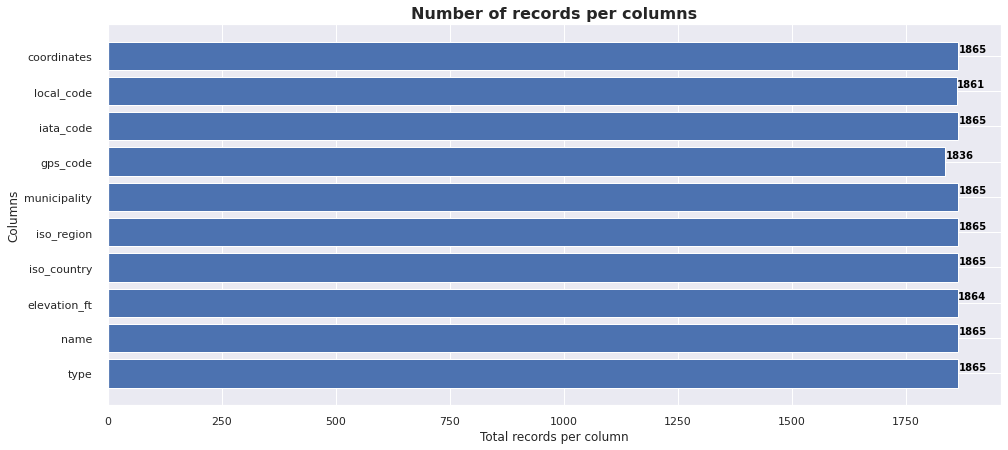

In [10]:
grapND (df_airport[~pd.isnull(df_airport)].count().index,
         df_airport[~pd.isnull(df_airport)].count().values, 'Total records per column', 'Columns','Number of records per columns')

#### Cleaning GlobalLandTemperaturesByCity
We extract the following columns City, Country, Latitude, Longitude and filter by United State country.

In [11]:
temperature = pd.read_csv('../data2/GlobalLandTemperaturesByCity.csv',sep=',',quoting=csv.QUOTE_NONE)
temperatureUS = temperature.loc[(temperature.Country == 'United States'),['City','Country','Latitude','Longitude']].drop_duplicates().copy()
temperatureUS.head()

City        Country Latitude Longitude
47555       Abilene  United States   32.95N   100.53W
137066        Akron  United States   40.99N    80.95W
168075  Albuquerque  United States   34.56N   107.03W
187528   Alexandria  United States   39.38N    76.99W
202251    Allentown  United States   40.99N    74.56W

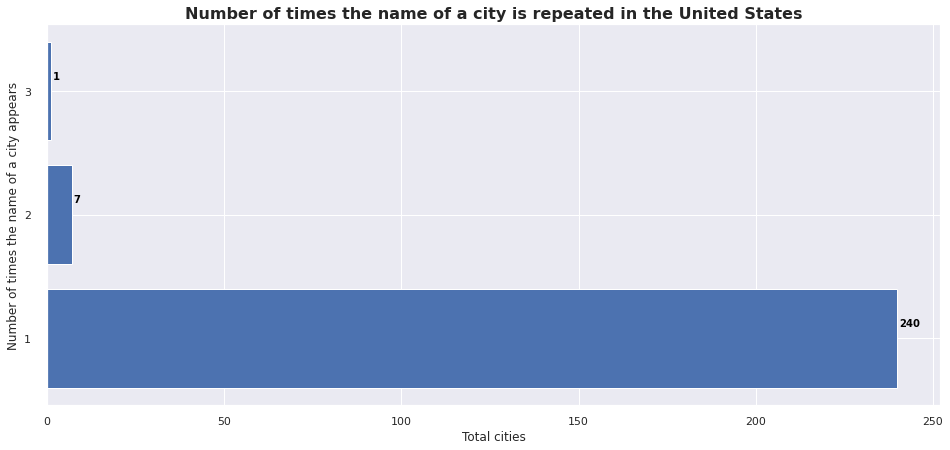

In [12]:
(y, x) = np.unique(temperatureUS.City.value_counts().values, return_counts=True)
grapND (y, x, "Total cities", "Number of times the name of a city appears", "Number of times the name of a city is repeated in the United States")

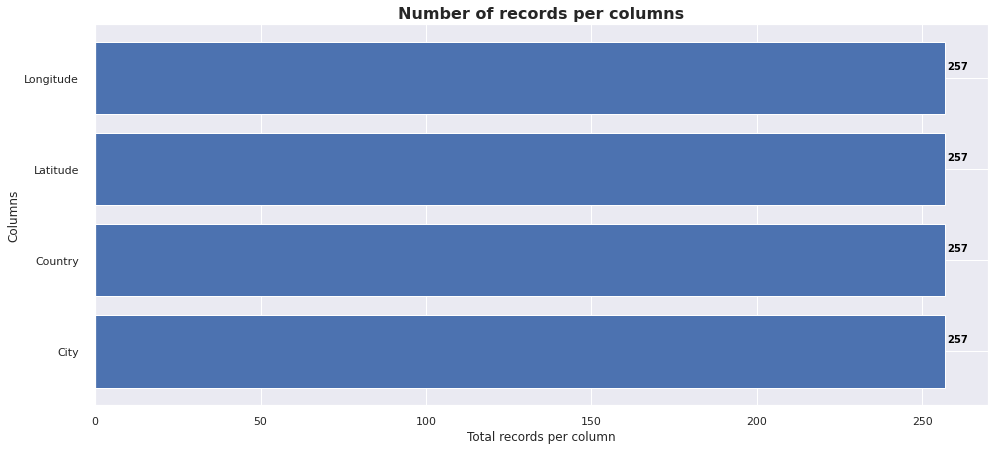

In [13]:
grapND (temperatureUS[~pd.isnull(temperatureUS)].count().index,
         temperatureUS[~pd.isnull(temperatureUS)].count().values, 'Total records per column', 'Columns','Number of records per columns')

#### Cleaning us-cities-demographics
Rows where Male Population or Female Population are null are eliminated and only the City, State, Median Age, Male Population, Female Population, Total Population, Number of Veterans, Foreign-born, Average Household Size, State Code columns are selected and remove duplicates.

In [14]:
# We filter by the following fields City, State, Median Age, Male Population, Female Population, Total Population, Number of Veterans, Foreign-born, Average Household Size, State Code and eliminate duplicates.
df_demographics = pd.read_csv('us-cities-demographics.csv',sep=';', encoding="ISO-8859-1")
df_demographicsUS = df_demographics.loc[(~df_demographics['Male Population'].isnull() | ~df_demographics['Female Population'].isnull()),
                                        ['City','State','Median Age','Male Population','Female Population','Total Population','Number of Veterans','Foreign-born','Average Household Size','State Code']].drop_duplicates().copy()

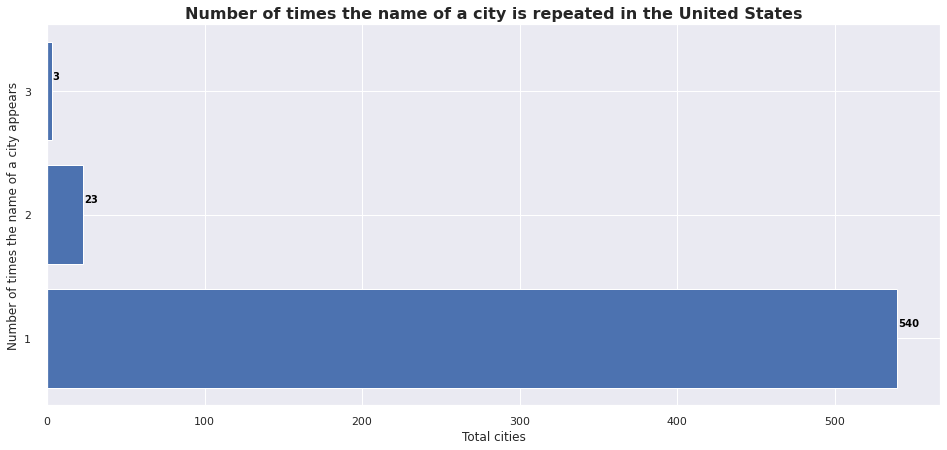

In [15]:
(y, x) = np.unique(df_demographicsUS.City.value_counts().values, return_counts=True)
grapND(y, x, "Total cities", "Number of times the name of a city appears", "Number of times the name of a city is repeated in the United States")

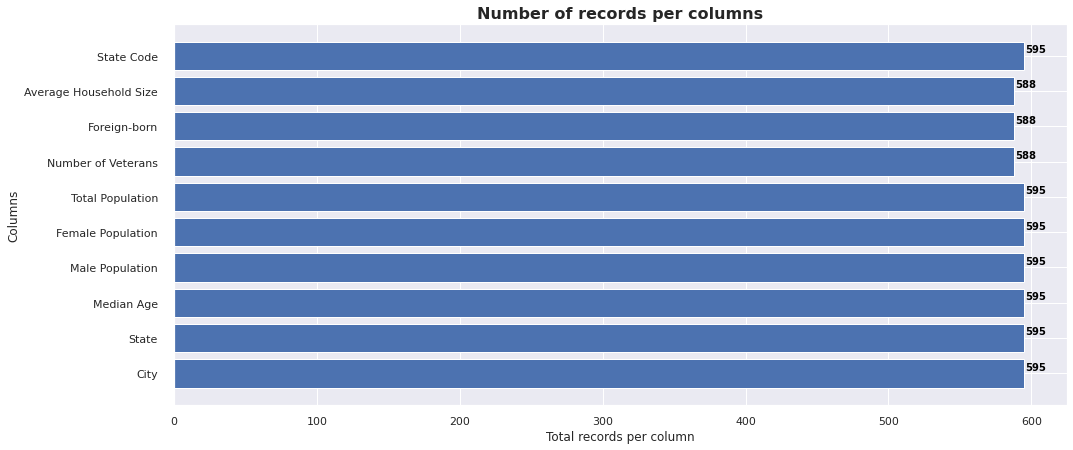

In [16]:
# Conteo de nulos.
grapND (df_demographicsUS[~pd.isnull(df_demographicsUS)].count().index,
         df_demographicsUS[~pd.isnull(df_demographicsUS)].count().values, 'Total records per column', 'Columns','Number of records per columns')

In [17]:
# We filter by the following fields City, State, State Code, Race and Count. We eliminate duplicates.
df_demographicsRaceUS = df_demographics.loc[:,['City','State','State Code', 'Race', 'Count']].drop_duplicates().copy()
df_demographicsRaceUS.head()

City          State State Code                       Race  \
0     Silver Spring       Maryland         MD         Hispanic or Latino   
1            Quincy  Massachusetts         MA                      White   
2            Hoover        Alabama         AL                      Asian   
3  Rancho Cucamonga     California         CA  Black or African-American   
4            Newark     New Jersey         NJ                      White   

   Count  
0  25924  
1  58723  
2   4759  
3  24437  
4  76402

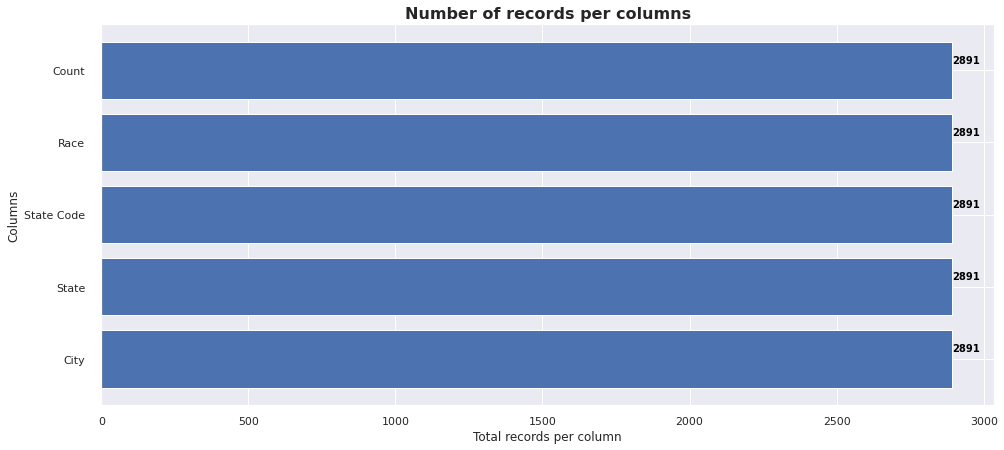

In [18]:
grapND(df_demographicsRaceUS[~pd.isnull(df_demographicsRaceUS)].count().index,
          df_demographicsRaceUS[~pd.isnull(df_demographicsRaceUS)].count().values, 'Total records per column', 'Columns','Number of records per columns')

#### Cleaning immigration_data
The null values of the i94addr field are eliminated and the columns occupy, entdepu, insnum are eliminated

In [7]:
df_spark = df_spark.na.drop("all", subset=["i94addr"]).drop("occup","entdepu","insnum")
df_sparkPandas = df_spark.select([count(when(~isnull(c), c)).alias(c) for c in df_spark.columns]).toPandas().transpose()

In [10]:
df_spark.show(5)

+-----+------+------+------+------+-------+-------+-------+-------+-------+------+-------+-----+--------+--------+-------+-------+-------+-------+--------+------+-------+--------------+-----+--------+
|cicid| i94yr|i94mon|i94cit|i94res|i94port|arrdate|i94mode|i94addr|depdate|i94bir|i94visa|count|dtadfile|visapost|entdepa|entdepd|matflag|biryear| dtaddto|gender|airline|        admnum|fltno|visatype|
+-----+------+------+------+------+-------+-------+-------+-------+-------+------+-------+-----+--------+--------+-------+-------+-------+-------+--------+------+-------+--------------+-----+--------+
|  7.0|2016.0|   4.0| 254.0| 276.0|    ATL|20551.0|    1.0|     AL|   null|  25.0|    3.0|  1.0|20130811|     SEO|      G|   null|   null| 1991.0|     D/S|     M|   null|  3.73679633E9|00296|      F1|
| 15.0|2016.0|   4.0| 101.0| 101.0|    WAS|20545.0|    1.0|     MI|20691.0|  55.0|    2.0|  1.0|20160401|    null|      T|      O|      M| 1961.0|09302016|     M|     OS|  6.66643185E8|   93|     

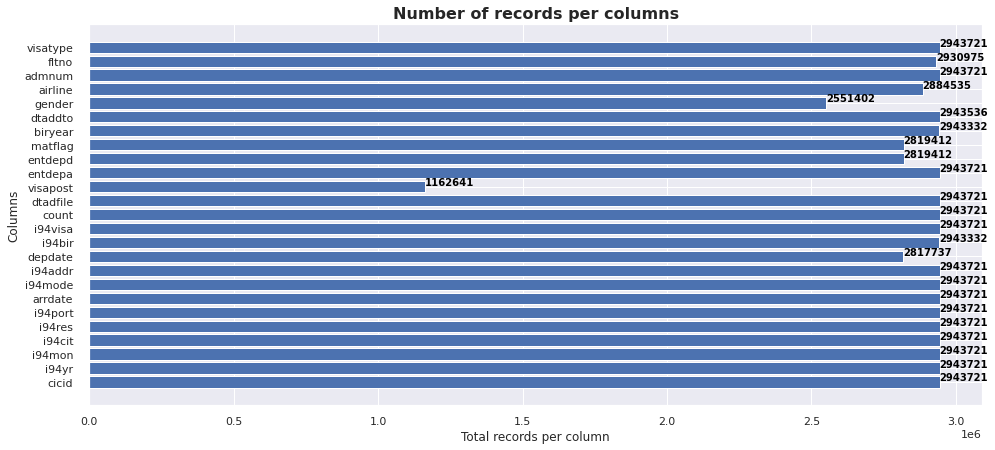

In [122]:
grapND(df_sparkPandas.index.to_list(),
         df_sparkPandas[0].to_list(), 'Total records per column', 'Columns','Number of records per columns')

### Step 3: Define the Data Model
#### 3.1 Conceptual Data Model
Map out the conceptual data model and explain why you chose that model

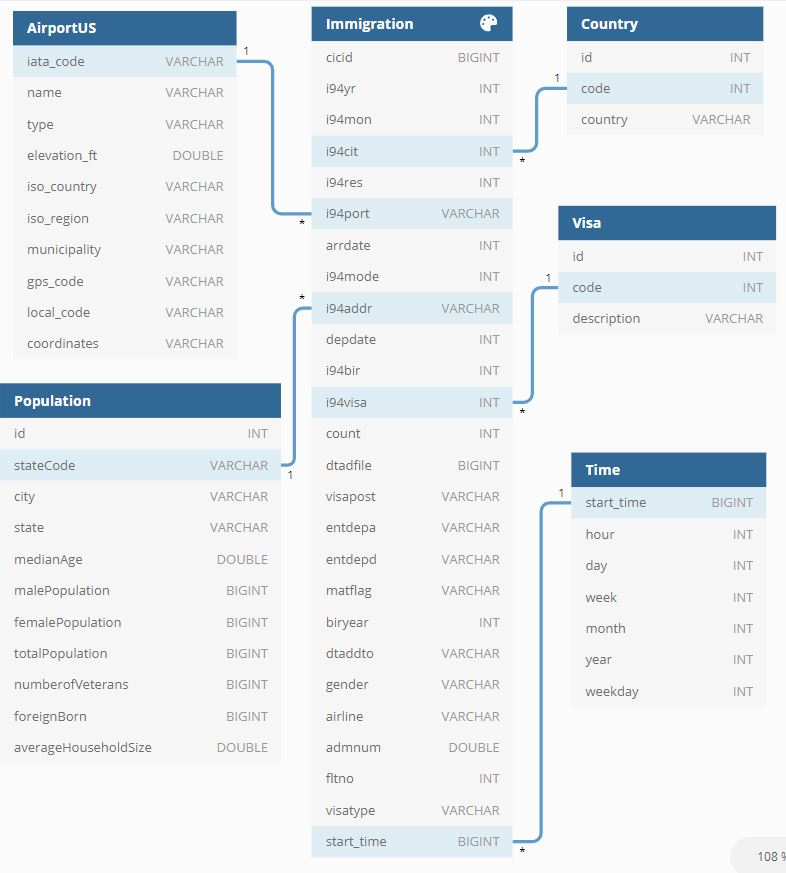

#### 3.2 Mapping Out Data Pipelines
List the steps necessary to pipeline the data into the chosen data model

* Create model tables.
* Clear the data.
* Load data into tables.
* Insert the data into the model.

### Step 4: Run Pipelines to Model the Data 
#### 4.1 Create the data model
Build the data pipelines to create the data model.

In [ ]:
# Write code here

def lodaData(cur, df, insert):
    for row in df.values:
        try:
            cur.execute(insert, list(row))
        except Exception as e:
            print(e)
    conn.commit()

In [ ]:
## Drop tabla.
population_table_drop = "DROP TABLE IF EXISTS population;"
country_table_drop = "DROP TABLE IF EXISTS country;"
visa_table_drop = "DROP TABLE IF EXISTS visa;"
airportus_table_drop = "DROP TABLE IF EXISTS airportus;"
time_table_drop = "DROP TABLE IF EXISTS time;"
immigration_table_drop = "DROP TABLE IF EXISTS immigration;"

In [ ]:
#Create 
time_table_create = ("""
CREATE TABLE IF NOT EXISTS time (
  "start_time" BIGINT PRIMARY KEY,
  "hour" INT NOT NULL,
  "day" INT NOT NULL,
  "week" INT NOT NULL,
  "month" INT NOT NULL,
  "year" INT NOT NULL,
  "weekday" INT NOT NULL
);""")


staging_immigration_table_create = ("""
CREATE TABLE IF NOT EXISTS staging_immigration (
  "cicid" BIGINT not null,
  "i94yr" INT NULL,
  "i94mon" INT NULL,
  "i94cit" INT NULL,
  "i94res" INT NULL,
  "i94port" VARCHAR(6) NOT NULL,
  "arrdate" INT NOT NULL,
  "i94mode" INT NULL,
  "i94addr" VARCHAR(60) NULL,
  "depdate" INT NULL,
  "i94bir" INT NULL,
  "i94visa" INT NOT NULL,
  "count" INT NULL,
  "dtadfile" VARCHAR(20) NULL,
  "visapost" VARCHAR(60) NULL,
  "entdepa" VARCHAR(8) NULL,
  "entdepd" VARCHAR(8) NULL,
  "matflag" VARCHAR(8) NULL,
  "biryear" INT NULL,
  "dtaddto" VARCHAR(8) NULL,
  "gender" VARCHAR(1) NULL,
  "airline" VARCHAR(8) NULL,
  "admnum" BIGINT NULL,
  "fltno" VARCHAR(8) NULL,
  "visatype" VARCHAR(4) NULL,
  "start_time" BIGINT NOT NULL
);""")

immigration_table_create = ("""
CREATE TABLE IF NOT EXISTS immigration (
  "id" INT IDENTITY(0,1) PRIMARY KEY,
  "cicid" BIGINT not null,
  "i94yr" INT NULL,
  "i94mon" INT NULL,
  "i94cit" INT NULL,
  "i94res" INT NULL,
  "i94port" VARCHAR(6) NOT NULL,
  "arrdate" INT NOT NULL,
  "i94mode" INT NULL,
  "i94addr" VARCHAR(60) NULL,
  "depdate" INT NULL,
  "i94bir" INT NULL,
  "i94visa" INT NOT NULL,
  "count" INT NULL,
  "dtadfile" VARCHAR(20) NULL,
  "visapost" VARCHAR(60) NULL,
  "entdepa" VARCHAR(8) NULL,
  "entdepd" VARCHAR(8) NULL,
  "matflag" VARCHAR(8) NULL,
  "biryear" INT NULL,
  "dtaddto" VARCHAR(8) NULL,
  "gender" VARCHAR(1) NULL,
  "airline" VARCHAR(8) NULL,
  "admnum" BIGINT NULL,
  "fltno" VARCHAR(8) NULL,
  "visatype" VARCHAR(4) NULL,
  "start_time" BIGINT NOT NULL
);""")


airportus_table_create = ("""
CREATE TABLE IF NOT EXISTS airportus (
  "iata_code" VARCHAR(6) PRIMARY KEY,
  "name" VARCHAR(255) NOT NULL,
  "type" VARCHAR(60) NOT NULL,
  "elevation_ft" NUMERIC PRECISION NULL,
  "iso_country" VARCHAR(10) NOT NULL,
  "iso_region" VARCHAR(20) NOT NULL,
  "municipality" VARCHAR(120) NOT NULL,
  "gps_code" VARCHAR(60) NULL,
  "local_code" VARCHAR(60) NULL,
  "coordinates" VARCHAR(80) NOT NULL
);""")

visa_table_create = ("""
CREATE TABLE IF NOT EXISTS visa (
  "id" INT IDENTITY(0,1) PRIMARY KEY,
  "code" INT NOT NULL,
  "description" VARCHAR(60) NOT NULL
);""")

country_table_create = ("""
CREATE TABLE IF NOT EXISTS country (
  "id" INT IDENTITY(0,1) PRIMARY KEY,
  "code" INT NOT NULL,
  "country" VARCHAR(255) NOT NULL
);""")

population_table_create = ("""
CREATE TABLE IF NOT EXISTS population (
  "id" INT IDENTITY(0,1) PRIMARY KEY,
  "stateCode" VARCHAR(255) NOT NULL,
  "city" VARCHAR(255) NOT NULL,
  "state" VARCHAR(255) NOT NULL,
  "medianAge" NUMERIC NOT NULL,
  "malePopulation" BIGINT  NOT NULL,
  "femalePopulation" BIGINT NOT NULL,
  "totalPopulation" BIGINT  NOT NULL,
  "numberofVeterans" BIGINT NULL,
  "foreignBorn" BIGINT NULL,
  "averageHouseholdSize" NUMERIC NULL
);""")


In [41]:
airportus_table_insert = ("""
    INSERT INTO airportus (iata_code, name, "type", elevation_ft, iso_country, iso_region, municipality, gps_code, local_code, coordinates)
    VALUES(%s, %s, %s, %s, %s, %s, %s, %s, %s, %s);
""")

country_table_insert = ("""
    INSERT INTO country (code, country) VALUES(%s, %s);
""")

visa_table_insert = ("""
    INSERT INTO visa (code, description) VALUES(%s, %s);
""")

population_table_insert = ("""
    INSERT INTO population (statecode, city, state, medianage, malepopulation, femalepopulation, totalpopulation, numberofveterans, foreignborn, averagehouseholdsize)
    VALUES(%s, %s, %s, %s, %s, %s, %s, %s, %s, %s);
""")

time_table_insert = ("""
    INSERT INTO "time" (start_time, "day", week, "month", "year", weekday)
    VALUES(%s, %s, %s, %s, %s, %s);
""")

copy_table = ("""
    COPY {}
    FROM '{}'
    ACCESS_KEY_ID '{}'
    SECRET_ACCESS_KEY '{}'
    FORMAT AS PARQUET;
""")



In [10]:
DIR_S3 = 's3a://proyectuda/'

In [9]:
df_spark = df_spark.na.drop("all", subset=["i94addr"]).drop("occup","entdepu","insnum") \
           .withColumn("start_time", convertTime(df_spark.arrdate)) \
           .withColumn("start_time_date", get_timestamp(col("start_time")))

In [11]:
%%time
df_spark.selectExpr('cast(cicid AS int) as cicid', ' cast(i94yr AS int) as i94yr',' cast(i94mon AS int) as i94mon','cast(i94cit AS int) as i94cit','cast(i94res AS int) as i94res','i94port',
                'cast(arrdate AS int) as arrdate','cast(i94mode AS int)i94mode',
                'i94addr','cast(depdate AS int) as depdate','cast(i94bir AS int) as i94bir','cast(i94visa AS int) as i94visa','cast(count AS int) as count','dtadfile','visapost','entdepa',
                'entdepd','matflag','cast(cicid AS int) biryear','dtaddto','gender','airline','cast(admnum AS int) as admnum','fltno',
                'visatype','start_time').write.parquet("immigration_data",mode='overwrite')

CPU times: user 9.67 ms, sys: 171 Âµs, total: 9.84 ms
Wall time: 24.3 s


In [44]:
%%time
df_immigration = spark.read.parquet('immigration_data')
df_immigration.write.option("compression","none").parquet(f'{BKS3A}' + "immigration",mode='overwrite')

CPU times: user 0 ns, sys: 1.89 ms, total: 1.89 ms
Wall time: 214 ms


In [45]:
df_immigration.count()

2943721

In [ ]:
try:
    cur.execute(copy_table.format('immigration',f'{BKS3}'.replace('s3a','s3') + "immigration/", 
                       os.environ['AWS_ACCESS_KEY_ID'],
                       os.environ['AWS_SECRET_ACCESS_KEY']))
    conn.commit()
except Exception as e:
    print(e)
    conn.rollback()

In [46]:
%%time
df_time = df_spark.select("start_time","start_time_date") \
               .withColumn("day",dayofmonth(col("start_time_date"))) \
                .withColumn("week",weekofyear(col("start_time_date"))) \
                .withColumn("month",month(col("start_time_date"))) \
                .withColumn("year",year(col("start_time_date"))) \
                .withColumn("weekday",date_format(col("start_time_date"), 'u')) \
                .selectExpr('cast(start_time as string) as start_time', 'cast(day as string) as day', 'cast(week as string) AS week', 'cast(month as string) AS month', 'cast(year as string) AS year', 'cast(weekday as string) AS weekday ').distinct().toPandas()

CPU times: user 20.1 ms, sys: 11.4 ms, total: 31.4 ms
Wall time: 1min 4s


In [19]:
lodaData(cur, time_table, time_table_insert)

In [93]:
df_population = pd.read_csv('us-cities-demographics.csv',sep=';', encoding="ISO-8859-1")
df_population = df_population.loc[(~df_population['Male Population'].isnull() | ~df_population['Female Population'].isnull()),
                                        ['State Code','City','State','Median Age','Male Population','Female Population','Total Population','Number of Veterans','Foreign-born','Average Household Size']] \
.drop_duplicates().fillna(value={'Number of Veterans': 0, 'Foreign-born': 0, 'Average Household Size': 0}).copy()
df_population.head()

State Code              City          State  Median Age  Male Population  \
0         MD     Silver Spring       Maryland        33.8          40601.0   
1         MA            Quincy  Massachusetts        41.0          44129.0   
2         AL            Hoover        Alabama        38.5          38040.0   
3         CA  Rancho Cucamonga     California        34.5          88127.0   
4         NJ            Newark     New Jersey        34.6         138040.0   

   Female Population  Total Population  Number of Veterans  Foreign-born  \
0            41862.0             82463              1562.0       30908.0   
1            49500.0             93629              4147.0       32935.0   
2            46799.0             84839              4819.0        8229.0   
3            87105.0            175232              5821.0       33878.0   
4           143873.0            281913              5829.0       86253.0   

   Average Household Size  
0                    2.60  
1                    2.39  
2                    2.58  
3                    3.18  
4                    2.73

In [27]:
lodaData(cur, df_population, population_table_insert)

In [97]:
df_airportus = pd.read_csv('airport-codes_csv.csv', encoding="ISO-8859-1")
df_airportus = df_airportus.drop(['continent','ident'],axis=1).loc[(df_airportus.type.isin(['small_airport','medium_airport','large_airport']) & df_airportus.iso_country.isin(['US'])),
                                                               ['iata_code', 'name', 'type', 'elevation_ft', 'iso_country', 'iso_region',
                                                                'municipality', 'gps_code', 'local_code', 'coordinates']].dropna(how='all',subset=['iata_code'])
df_airportus.shape

(1865, 10)

In [29]:
lodaData(cur, df_airportus, airportus_table_insert)

In [66]:
df_country = pd.read_csv('static_data/COUNTRIES.csv',sep=';',quoting=csv.QUOTE_NONE)
df_country.head()

ID                                            COUNTRY
0  582  MEXICO Air Sea, and Not Reported (I-94, no lan...
1  236                                        AFGHANISTAN
2  101                                            ALBANIA
3  316                                            ALGERIA
4  102                                            ANDORRA

In [24]:
lodaData(cur, df_countries, country_table_insert)

In [30]:
df_visa = pd.read_csv('static_data/VISA.csv',sep=';',quoting=csv.QUOTE_NONE)
df_visa.head()

ID DESCRIPTION
0   1    Business
1   2    Pleasure
2   3     Student

In [42]:
lodaData(cur, df_visa, visa_table_insert)

#### 4.2 Data Quality Checks
Explain the data quality checks you'll perform to ensure the pipeline ran as expected. These could include:
 * Integrity constraints on the relational database (e.g., unique key, data type, etc.)
 * Unit tests for the scripts to ensure they are doing the right thing
 * Source/Count checks to ensure completeness
 
Run Quality Checks

In [98]:
# Perform quality checks here
data_quality = ['time','visa','country','airportus','immigration']

for tbl in data_quality:
    qry = "SELECT COUNT(1) FROM " + tbl
    cur.execute(qry)
    reg_db = cur.fetchone()[0]

    print(f"db records {reg_db} for {tbl}")

db records 90 equals dataframe records 30 for time
db records 3 equals dataframe records 3 for visa
db records 289 equals dataframe records 289 for country
db records 1876 equals dataframe records 1865 for airportus
db records 2943721 equals dataframe records 2943721 for immigration


#### 4.3 Data dictionary 
Create a data dictionary for your data model. For each field, provide a brief description of what the data is and where it came from. You can include the data dictionary in the notebook or in a separate file.

#### Time.
<table class="tg" align="left">
  <tbody>
  <tr>
    <th class="tg-0pky">Fields</th>
    <th class="tg-0pky">Description</th>
  </tr>
 <tr>
<td class="tg-0pky">start_time</td>
<td class="tg-0pky">Time in timestamp</td>
 </tr>
<tr>
<td class="tg-0pky">day</td>
<td class="tg-0pky">Day of the month</td>
 </tr>
<tr>
<td class="tg-0pky">week</td>
<td class="tg-0pky">Week number</td>
 </tr>
<tr>
<td class="tg-0pky">month</td>
<td class="tg-0pky">Month of the year</td>
 </tr>
<tr>
<td class="tg-0pky">year</td>
<td class="tg-0pky">Year</td>
 </tr>
<tr>
<td class="tg-0pky">weekday</td>
<td class="tg-0pky">Day of the week in number</td>
 </tr>
</tbody>
</table>

#### Airportus.
<table class="tg" align="left">
  <tbody><tr>
    <th class="tg-0pky">Fields</th>
    <th class="tg-0pky">Description</th>
  </tr>
<tr>
<td class="tg-0pky">iata_code</td>
<td class="tg-0pky">IATA location identifier</td>
 </tr>
      <tr>
<td class="tg-0pky">name</td>
<td class="tg-0pky">Airport name</td>
 </tr>
<tr>
<td class="tg-0pky">type</td>
<td class="tg-0pky">Airport size</td>
 </tr>

<tr>
<td class="tg-0pky">elevation_ft</td>
<td class="tg-0pky">elevation feet</td>
 </tr>
<tr>
<td class="tg-0pky">iso_country</td>
<td class="tg-0pky">Codes are two-letter country codes </td>
 </tr>
<tr>
<td class="tg-0pky">iso_region</td>
<td class="tg-0pky">Contains a set of 2-digit region codes</td>
 </tr>
<tr>
<td class="tg-0pky">municipality</td>
<td class="tg-0pky">Municipality</td>
 </tr>
<tr>
<td class="tg-0pky">gps_code</td>
<td class="tg-0pky">Airport codes is used to display an airport's location identifiers or "airport codes".</td>
 </tr>

<tr>
<td class="tg-0pky">local_code</td>
<td class="tg-0pky">local code</td>
 </tr>
<tr>
<td class="tg-0pky">coordinates</td>
<td class="tg-0pky">coordinates</td>
 </tr>
</tbody></table>



#### Population.
<table class="tg" align="left">
  <tbody><tr>
    <th class="tg-0pky">Fields</th>
    <th class="tg-0pky">Description</th>
  </tr>
            <tr>
<td class="tg-0pky">id</td>
<td class="tg-0pky">Secuence</td>
 </tr>
      <tr>
<td class="tg-0pky">statecode</td>
<td class="tg-0pky">US states code</td>
 </tr>
 <tr>
<td class="tg-0pky">city</td>
<td class="tg-0pky">City</td>
 </tr>
<tr>
<td class="tg-0pky">state</td>
<td class="tg-0pky">State</td>
 </tr>
<tr>
<td class="tg-0pky">medianage</td>
<td class="tg-0pky">Median Age</td>
 </tr>
<tr>
<td class="tg-0pky">malepopulation</td>
<td class="tg-0pky">Male Population</td>
 </tr>
<tr>
<td class="tg-0pky">femalepopulation</td>
<td class="tg-0pky">Female Population</td>
 </tr>
<tr>
<td class="tg-0pky">totalpopulation</td>
<td class="tg-0pky">Total Population</td>
 </tr>
<tr>
<td class="tg-0pky">numberofveterans</td>
<td class="tg-0pky">Number of Veterans</td>
 </tr>
<tr>
<td class="tg-0pky">foreignborn</td>
<td class="tg-0pky">Foreign-born</td>
 </tr>
<tr>
<td class="tg-0pky">averagehouseholdsize</td>
<td class="tg-0pky">Average Household Size</td>
 </tr>

</tbody></table>

#### Immigration

<table class="tg" align="left">
  <tbody><tr>
    <th class="tg-0pky">Fields</th>
    <th class="tg-0pky">Description</th>
  </tr>
                  <tr>
<td class="tg-0pky">id</td>
<td class="tg-0pky">Secuence</td>
 </tr>
 <tr>
<td class="tg-0pky">cicid</td>
<td class="tg-0pky">CICID is a unique number for the immigrants</td>
 </tr>
<tr>
<td class="tg-0pky">i94yr</td>
<td class="tg-0pky">4 digit year</td>
 </tr>
<tr>
<td class="tg-0pky">i94mon</td>
<td class="tg-0pky">Numeric month</td>
 </tr>
<tr>
<td class="tg-0pky">i94cit</td>
<td class="tg-0pky">3 digit code of origin city</td>
 </tr>
<tr>
<td class="tg-0pky">i94res</td>
<td class="tg-0pky">Country from where one has travelled</td>
 </tr>
<tr>
<td class="tg-0pky">i94port</td>
<td class="tg-0pky">3 character code of destination USA city</td>
 </tr>
<tr>
<td class="tg-0pky">arrdate</td>
<td class="tg-0pky">Date of arrrival</td>
 </tr>
<tr>
<td class="tg-0pky">i94mode</td>
<td class="tg-0pky">1 digit travel code  (1 = Air; 2 = Sea; 3 = Land; 9 = Not reported)</td>
 </tr>
<tr>
<td class="tg-0pky">i94addr</td>
<td class="tg-0pky">Where the immigrants resides in USA </td>
 </tr>
<tr>
<td class="tg-0pky">depdate</td>
<td class="tg-0pky">Departure Date from the USA</td>
 </tr>
<tr>
<td class="tg-0pky">i94bir</td>
<td class="tg-0pky">Age of Respondent in Years</td>
 </tr>
<tr>
<td class="tg-0pky">i94visa</td>
<td class="tg-0pky">Visa codes collapsed into three categories (1 = Business; 2 = Pleasure; 3 = Student)</td>
 </tr>
<tr>
<td class="tg-0pky">count</td>
<td class="tg-0pky">Used for summary statistics</td>
 </tr>
<tr>
<td class="tg-0pky">dtadfile</td>
<td class="tg-0pky">Character Date Field - Date added to I-94 Files</td>
 </tr>
<tr>
<td class="tg-0pky">visapost</td>
<td class="tg-0pky">Department of State where where Visa was issued </td>
 </tr>
<tr>
<td class="tg-0pky">entdepa</td>
<td class="tg-0pky">Arrival Flag - admitted or paroled into the U.S.</td>
 </tr>
<tr>
<td class="tg-0pky">entdepd</td>
<td class="tg-0pky">Departure Flag - Departed, lost I-94 or is deceased</td>
 </tr>
<tr>
<td class="tg-0pky">matflag</td>
<td class="tg-0pky">Match flag - Match of arrival and departure records</td>
 </tr>
<tr>
<td class="tg-0pky">biryear</td>
<td class="tg-0pky">4 digit year of birth</td>
 </tr>
<tr>
<td class="tg-0pky">dtaddto</td>
<td class="tg-0pky">Character Date Field - Date to which admitted to U.S. (allowed to stay until)</td>
 </tr>
<tr>
<td class="tg-0pky">gender</td>
<td class="tg-0pky">Non-immigrant sex</td>
 </tr>
<tr>
<td class="tg-0pky">airline</td>
<td class="tg-0pky">Airline used to arrive in U.S.</td>
 </tr>
<tr>
<td class="tg-0pky">admnum</td>
<td class="tg-0pky">Admission Number</td>
 </tr>
<tr>
<td class="tg-0pky">fltno</td>
<td class="tg-0pky">Flight number of Airline used to arrive in U.S.</td>
 </tr>
<tr>
<td class="tg-0pky">visatype</td>
<td class="tg-0pky">Class of admission legally admitting the non-immigrant to temporarily stay in U.S.</td>
</tr>
  <tr>
<td class="tg-0pky">start_time</td>
<td class="tg-0pky">Time in timestamp</td>
 </tr>
</tbody></table>

#### Visa
<table class="tg" align="left">
  <tbody><tr>
    <th class="tg-0pky">Fields</th>
    <th class="tg-0pky">Description</th>
  </tr>
 <tr>
<td class="tg-0pky">id</td>
<td class="tg-0pky">Secuence</td>
 </tr>
<tr>
<td class="tg-0pky">code</td>
<td class="tg-0pky">Code Visa</td>
 </tr>
 <tr>
<td class="tg-0pky">description</td>
<td class="tg-0pky">Description Visa</td>
 </tr>
</table>

#### Country
<table class="tg" align="left">
  <tbody><tr>
    <th class="tg-0pky">Fields</th>
    <th class="tg-0pky">Description</th>
  </tr>
 <tr>
<td class="tg-0pky">id</td>
<td class="tg-0pky">Secuence</td>
 </tr>
<tr>
<td class="tg-0pky">code</td>
<td class="tg-0pky">Code country</td>
 </tr>
 <tr>
<td class="tg-0pky">country</td>
<td class="tg-0pky">Country</td>
 </tr>
</table>

#### Step 5: Complete Project Write Up
* Clearly state the rationale for the choice of tools and technologies for the project.

__The tools chosen were used throughout the course. And depending on the number of records in the files, pandas or spark is used for processing. We use Airflow to orchestrate the process. And for storage we use Redshift.__

* Propose how often the data should be updated and why.

__The frequency must be annual, because the publication of the dataset is annual__
* Write a description of how you would approach the problem differently under the following scenarios:
 * The data was increased by 100x.
 
__You can migrate the 100% aws code and use ERM__
 * The data populates a dashboard that must be updated on a daily basis by 7am every day.
 
__Airflow update frequency is adjusted__
 * The database needed to be accessed by 100+ people.
 
__We enable access to people in Redshift and the cluster capacity can be increase__